### Library Import

In [3]:
import os
import json
from collections import Counter

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings("ignore")

### Meta Data

In [4]:
file_path = '/data/ephemeral/home/data/meta_data.xlsx'
meta_data = pd.read_excel(file_path)

meta_data = meta_data.drop(columns=['ID', 'Unnamed: 5'])
meta_data['성별'] = meta_data['성별'].str.replace('_x0008_','',regex=False).str.strip()
meta_data['성별'] = meta_data['성별'].replace({'남': 'Male', '여': 'Female'})

In [5]:
meta_data.head()

,나이,성별,체중(몸무게),키(신장)
0,30,Female,63.0,165.0
1,21,Male,70.0,172.0
2,21,Female,48.0,164.0
3,30,Female,49.0,158.0
4,33,Female,50.0,160.0


In [6]:
meta_data.describe().T

,count,mean,std,min,25%,50%,75%,max
나이,550.0,31.865455,10.382489,19.0,25.0,29.0,36.0,69.0
체중(몸무게),550.0,64.516364,12.782005,42.0,55.0,63.0,74.0,118.0
키(신장),550.0,167.767455,7.956421,150.0,161.0,168.0,174.0,187.0


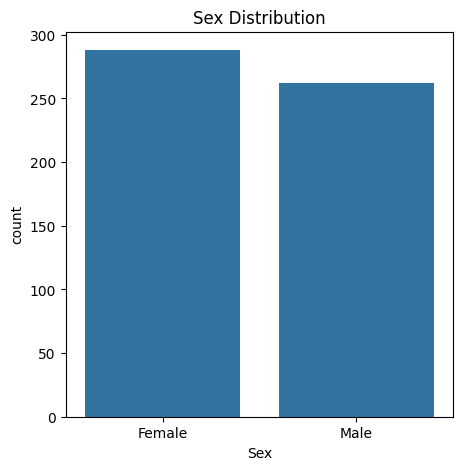

In [7]:
plt.figure(figsize=(5,5))
sns.countplot(x=meta_data['성별'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.show()

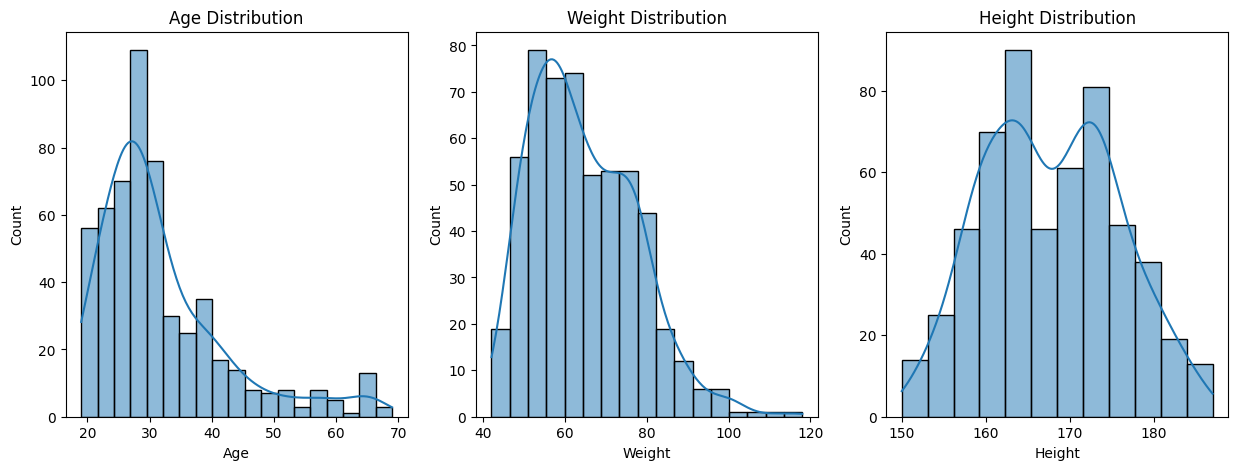

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(meta_data['나이'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')

sns.histplot(meta_data['체중(몸무게)'], kde=True, ax=axes[1])
axes[1].set_title('Weight Distribution')
axes[1].set_xlabel('Weight')

sns.histplot(meta_data['키(신장)'], kde=True, ax=axes[2])
axes[2].set_title('Height Distribution')
axes[2].set_xlabel('Height')

plt.show()

### 

- 추후 VLM에서 Meta Data가 가진 성별, 나이, 몸무게, 키 정보를 활용하려면 Meta Data와 Image/Annotation의 상관 관계 파악

### Image & Annotation

In [9]:
IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"
TEST_ROOT = "/data/ephemeral/home/data/test/DCM"

CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [10]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

tests = {
    os.path.relpath(os.path.join(root, fname), start=TEST_ROOT)
    for root, _dirs, files in os.walk(TEST_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"    
}

jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

pngs = sorted(pngs)
jsons = sorted(jsons)
tests = sorted(tests)

In [11]:
print("num of Images : ", len(pngs))
print("num of JSONs  : ", len(jsons))

num of Images :  800
num of JSONs  :  800


In [12]:
json_path = '/data/ephemeral/home/data/train/outputs_json/ID001/image1661130828152_R.json'

with open(json_path, 'r') as file :
    data = json.load(file)

print(data.keys())
print()
print('attributes : ', data['attributes'])
print('file_id : ', data['file_id'])
print('filename : ', data['filename'])
print('parent_path : ', data['parent_path'])
print('last_modifier_id : ', data['last_modifier_id'])
print('metadata : ', data['metadata'])
print('last_workers : ', data['last_workers'])

dict_keys(['annotations', 'attributes', 'file_id', 'filename', 'parent_path', 'last_modifier_id', 'metadata', 'last_workers'])

attributes :  {}
file_id :  637ef14e41c1bfb2ef9029e7
filename :  image1661130828152_R.jpg
parent_path :  /X-ray_UNIST/20220822/ID001
last_modifier_id :  5fa0b605a7b2076fa9f84c80
metadata :  {'height': 3060, 'width': 3060}
last_workers :  {'라벨링': '5fa0b605a7b2076fa9f84c80', '검수': None, '최종 검수': None}


In [13]:
data['annotations']

[{'id': '30-f037db6e-aef2-4156-93e2-8de7cc97869c',
  'type': 'poly_seg',
  'attributes': {},
  'points': [[960, 2047],
   [960, 2046],
   [960, 2045],
   [960, 2044],
   [960, 2043],
   [960, 2042],
   [960, 2041],
   [959, 2041],
   [959, 2040],
   [959, 2039],
   [959, 2038],
   [959, 2037],
   [959, 2036],
   [959, 2035],
   [959, 2034],
   [959, 2033],
   [959, 2032],
   [959, 2031],
   [959, 2030],
   [959, 2029],
   [959, 2028],
   [959, 2027],
   [959, 2026],
   [959, 2025],
   [958, 2025],
   [958, 2024],
   [958, 2023],
   [958, 2022],
   [958, 2021],
   [958, 2020],
   [958, 2019],
   [958, 2018],
   [958, 2017],
   [958, 2016],
   [958, 2015],
   [958, 2014],
   [958, 2013],
   [958, 2012],
   [958, 2011],
   [958, 2010],
   [958, 2009],
   [958, 2008],
   [958, 2007],
   [958, 2006],
   [958, 2005],
   [957, 2005],
   [957, 2004],
   [957, 2003],
   [957, 2002],
   [957, 2001],
   [957, 2000],
   [957, 1999],
   [957, 1998],
   [957, 1997],
   [957, 1996],
   [957, 1995],
 

In [14]:
label_counts = Counter()
for json_file in jsons:
    json_path = os.path.join(LABEL_ROOT, json_file)
    with open(json_path, 'r') as f:
        data = json.load(f)
        for annotation in data.get("annotations", []):
            label = annotation.get("label")
            label_counts[label] += 1

label_counts

Counter({'Radius': 800,
         'finger-1': 800,
         'finger-2': 800,
         'finger-3': 800,
         'finger-4': 800,
         'finger-5': 800,
         'finger-6': 800,
         'finger-7': 800,
         'finger-8': 800,
         'finger-9': 800,
         'finger-10': 800,
         'finger-11': 800,
         'finger-12': 800,
         'finger-13': 800,
         'finger-14': 800,
         'finger-15': 800,
         'finger-16': 800,
         'finger-17': 800,
         'finger-18': 800,
         'finger-19': 800,
         'Trapezoid': 800,
         'Scaphoid': 800,
         'Trapezium': 800,
         'Lunate': 800,
         'Triquetrum': 800,
         'Hamate': 800,
         'Capitate': 800,
         'Ulna': 800,
         'Pisiform': 800})

In [ ]:
for i in range(0, 800, 10):
    current_images = pngs[i:i + 10]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Images {i+1} to {i+len(current_images)}")
    
    for j, img_file in enumerate(current_images):
        img_path = os.path.join(IMAGE_ROOT, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        ax = axes[j // 5, j % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{img_file}")
        ax.axis('off')
    
    for j in range(len(current_images), 2 * 5):
        axes[j // 5, j % 5].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
for i in range(0, len(tests), 10):
    current_images = tests[i:i + 10]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Images {i+1} to {i+len(current_images)}")
    
    for j, img_file in enumerate(current_images):
        img_path = os.path.join(TEST_ROOT, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        ax = axes[j // 5, j % 5]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{img_file}")
        ax.axis('off')
    
    for j in range(len(current_images), 2 * 5):
        axes[j // 5, j % 5].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

### t-SNE

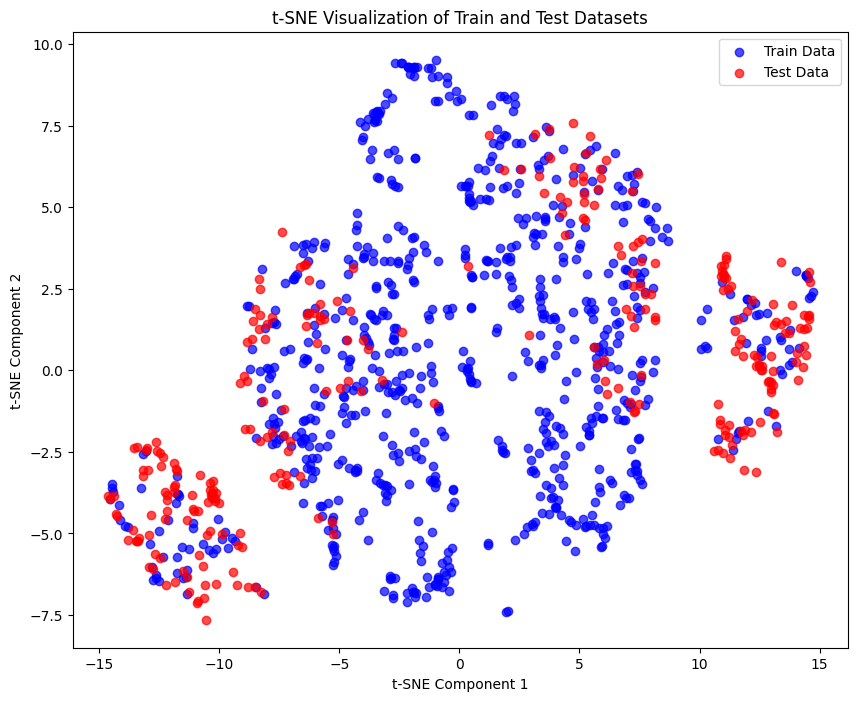

In [15]:
from sklearn.manifold import TSNE

image_size = (128, 128) # 64, 128, 256 ...

flattened_train_images = []
for img_file in pngs:
    img_path = os.path.join(IMAGE_ROOT, img_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    resized_image = cv2.resize(image, image_size)
    flattened_train_images.append(resized_image.flatten())

flattened_train_images = np.array(flattened_train_images)

flattened_test_images = []
for test_img_file in tests:
    test_img_path = os.path.join(TEST_ROOT, test_img_file)
    test_image = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)
    
    resized_test_image = cv2.resize(test_image, image_size)
    flattened_test_images.append(resized_test_image.flatten())

flattened_test_images = np.array(flattened_test_images)

all_images = np.vstack([flattened_train_images, flattened_test_images])

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(all_images)

train_tsne_result = tsne_result[:len(flattened_train_images)]
test_tsne_result = tsne_result[len(flattened_train_images):]

plt.figure(figsize=(10, 8))
plt.scatter(train_tsne_result[:, 0], train_tsne_result[:, 1], alpha=0.7, label="Train Data", c='blue')
plt.scatter(test_tsne_result[:, 0], test_tsne_result[:, 1], alpha=0.7, label="Test Data", c='red')
plt.title("t-SNE Visualization of Train and Test Datasets")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

### Annotation Visualization

In [16]:
class XRayDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        self.filenames = list(_filenames)
        self.labelnames = list(_labelnames)

        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        image = image.transpose(2, 0, 1) 
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label
    
train_dataset = XRayDataset()

In [17]:
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [ ]:
import matplotlib.pyplot as plt

for index in range(10):
    image, label = train_dataset[index]
    
    image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    label = label.numpy()

    image = (image * 255).astype(np.uint8)
    
    label_rgb = label2rgb(label)
    
    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image {index + 1}")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(label_rgb, alpha=0.3)
    plt.title(f"Segmentation {index + 1}")
    plt.axis("off")
    
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

image = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
label = label.numpy()  # (num_classes, H, W)

image = (image * 255).astype(np.uint8)

plt.figure(figsize=(20, 100))
plt.subplot(15, 2, 1) 
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

for class_idx in range(label.shape[0]):
    class_mask = label[class_idx]
    
    class_mask_rgb = np.zeros_like(image)
    class_mask_rgb[class_mask == 1] = PALETTE[class_idx]
    
    plt.subplot(15, 2, class_idx + 2)
    plt.imshow(image)
    plt.imshow(class_mask_rgb, alpha=0.3)
    plt.title(f"Class {IND2CLASS[class_idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
